In [2]:
# import packages
import pandas as pd
import numpy as np

# to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [3]:
df = pd.read_csv('../res/input0130.csv')

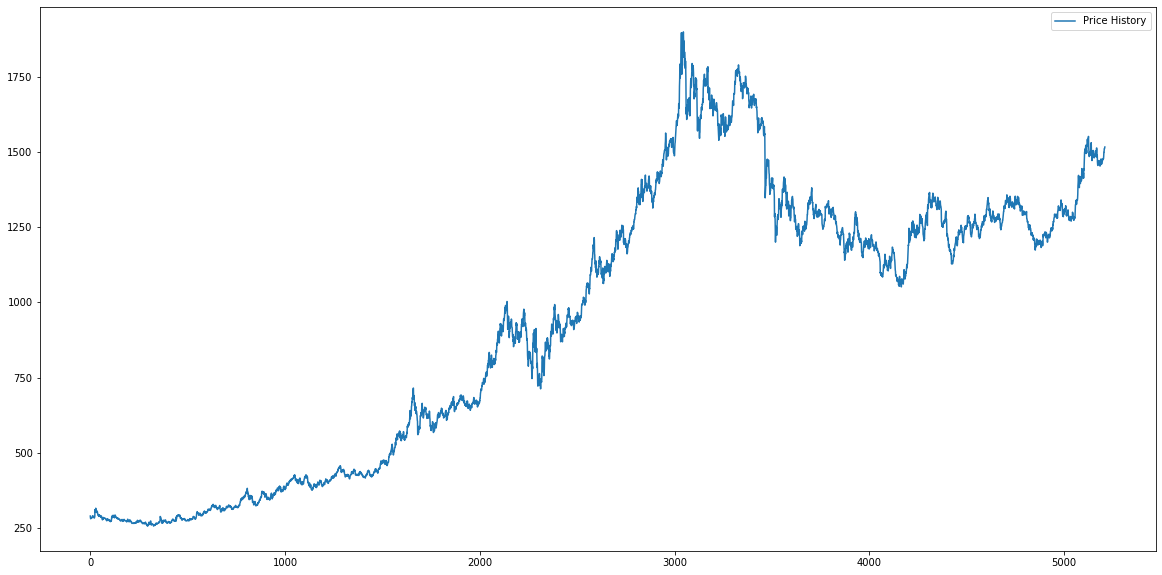

In [4]:
plt.plot(df['close'], label='Price History')
plt.legend()

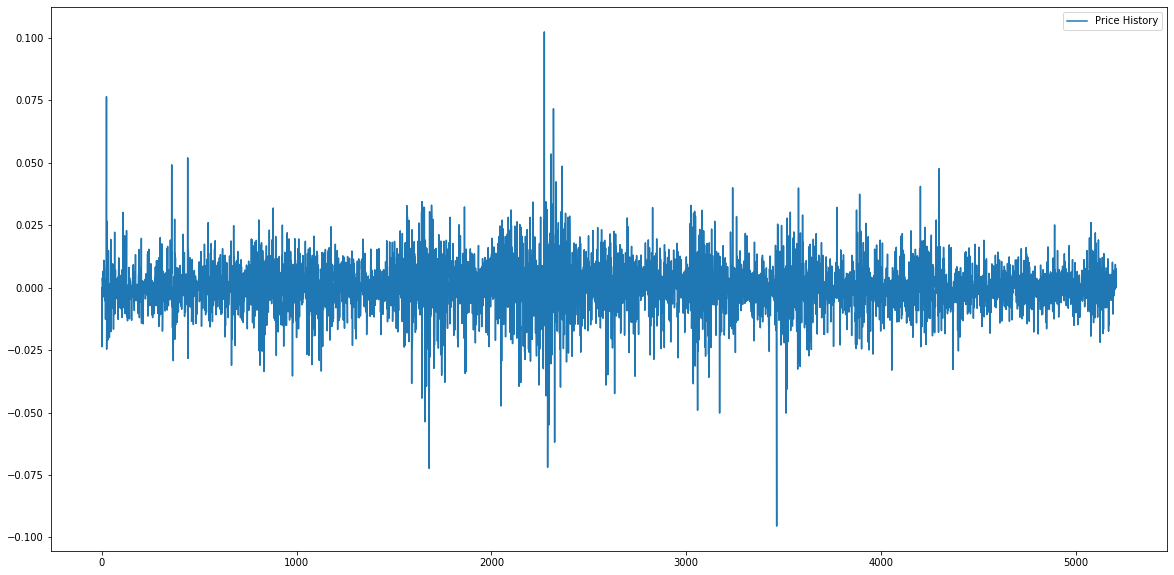

In [5]:
plt.plot(df['log_r'], label='Price History')
plt.legend()

In [6]:
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
# follow the literature
# we don't use min-max scaling here, use partial mean-std scaling instead
from sklearn.preprocessing import StandardScaler
from itertools import chain

# and we define our model here
def lstm_model(para_a=42, para_b=17):
    model = Sequential()
    model.add(LSTM(units=para_a, dropout=0.1, return_sequences=True, input_shape=(240,1),activation='tanh'))# (25,15)-57, (42,17)-58
    model.add(LSTM(units=para_b, dropout=0.08, activation='tanh'))
    # model.add(Dropout(0.08))# 加了之后同原先效果差不多，（应该一定程度上）可以防止过拟合
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [7]:
# we use rolling window, 750 bars for train and 250 for test
scaler = StandardScaler()
starter = range(240,len(df)-1000,250)
all_results = []
all_evas = []
y_pred_clf = []

In [8]:
for train_begin in starter:
    train_end = train_begin + 750
    test_end = train_end + 250
    train_set = df[['log_r','label']][train_begin:train_end].reset_index()
    x_train, y_train = [], []
    x_train_set = list(chain.from_iterable(scaler.fit_transform(train_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_train_set)):
        x_train.append(x_train_set[i-240:i])
        y_train.append(train_set['label'][i])
    x_train, y_train = np.array(x_train), np.array(y_train)
    y_train = to_categorical(y_train,2)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 
    
    model = lstm_model()
    # 原本未设置 batch_size，使用的是默认值，进行尝试：
    # (1)batch_size=8——可达0.62
    # (1)batch_size=18——可达0.58
    # (1)batch_size=5——可达0.60
    # 依然选择 batch_size=8，稳定在0.60左右的水平
    model.fit(x_train,y_train,epochs=30, batch_size=8, callbacks=[EarlyStopping(monitor='loss',patience=10)])

    x_test, y_test = [], []
    test_set = df[['log_r','label']][train_end-240:test_end].reset_index()
    x_test_set = list(chain.from_iterable(scaler.transform(test_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_test_set)):
        x_test.append(x_test_set[i-240:i])
        y_test.append(test_set['label'][i])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 
    y_test = to_categorical(y_test,2)
    
    all_results.append(model.predict(x_test))
    all_evas.append(model.evaluate(x_test, y_test))
    y_pred_clf.append(model.predict_classes(x_test))
    break

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
510/510 [==============================] - 24s 46ms/step - loss: 0.6929 - acc: 0.5157
Epoch 2/30
510/510 [==============================] - 22s 43ms/step - loss: 0.6936 - acc: 0.5392
Epoch 3/30
510/510 [==============================] - 15s 30ms/step - loss: 0.6920 - acc: 0.5275
Epoch 4/30
510/510 [==============================] - 14s 26ms/step - loss: 0.6922 - acc: 0.5451
Epoch 5/30
510/510 [==============================] - 14s 28ms/step - loss: 0.6916 - acc: 0.5353
Epoch 6/30
510/510 [==============================] - 15s 30ms/step - loss: 0.6918 - acc: 0.5353
Epoch 7/30
510/510 [==============================] - 16s 31ms/step - loss: 0.6913 - acc: 0.5294
Epoch 8/30
510/510 [==============================] - 16s 32ms/step - loss: 0.6929 - a

In [9]:
print([(y_test[i],y_pred_clf[i]) for i in range(0,min(len(y_test),len(y_pred_clf)))])

[(array([0., 1.], dtype=float32), array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))]


In [10]:
model.save('lstm_imp.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 240, 42)           7392      
_________________________________________________________________
lstm_2 (LSTM)                (None, 17)                4080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 36        
Total params: 11,508
Trainable params: 11,508
Non-trainable params: 0
_________________________________________________________________


In [11]:
from sklearn import metrics


for train_begin in starter:
    train_end = train_begin + 750
    test_end = train_end + 250
    train_set = df[['log_r','label']][train_begin:train_end].reset_index()
    x_train, y_train = [], []
    x_train_set = list(chain.from_iterable(scaler.fit_transform(train_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_train_set)):
        x_train.append(x_train_set[i-240:i])
        y_train.append(train_set['label'][i])
    x_train, y_train = np.array(x_train), np.array(y_train)
    # y_train = to_categorical(y_train,2)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 
    x_test, y_test = [], []
    test_set = df[['log_r','label']][train_end-240:test_end].reset_index()
    x_test_set = list(chain.from_iterable(scaler.transform(test_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_test_set)):
        x_test.append(x_test_set[i-240:i])
        y_test.append(test_set['label'][i])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 
    y_pred = model.predict_classes(x_train)
    # all_results.append(model.predict(x_test))
    print(metrics.accuracy_score(y_train, y_pred))
    # y_pred_clf.append(model.predict_classes(x_test))

0.5686274509803921
0.5607843137254902
0.5372549019607843
0.5313725490196078
0.5098039215686274
0.503921568627451
0.5019607843137255
0.5274509803921569
0.5607843137254902
0.5392156862745098
0.492156862745098
0.4843137254901961
0.49019607843137253
0.4803921568627451
0.5
0.5450980392156862


In [17]:

diff = [1 if y_pred[i]==y_train[i] else 0 for i in range(len(y_pred))]
print(diff)

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 